# Исследование закономерностей, определяющих успешность компьютерных игр

## Постановка задачи
В ходе исследования необходимо выявить определяющие успешность компьютерной игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Общая информация о данных

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 30)

In [3]:
# прочитаем файлы:
try:
    df = pd.read_csv("games.csv")
except:
    try:
        df = pd.read_csv("/datasets/games.csv")
    except:
        df = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")
        
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В качестве исходных данных предоставлена таблица, состоящая из 11 колонок и 16715 строк c различными типами данных (object, float64). 

Согласно документации к данным:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

В названиях колонок видны три нарушения стиля:

- Строчные буквы сочетаются с прописными.
- Встречаются пробелы.
- Названия колонок начинаются с прописных букв.

Типы данных некоторых колонок не соответствуют значениям. Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.


## Предобработка данных

### Обработка названий столбцов

Приведем названия столбцов к нижнему регистру.

In [5]:
col_name_lower = df.columns.str.lower()

df.columns = col_name_lower
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Обработка пропусков и приведение данных к нужным типам

В name и genre всего по два пропуска:

In [6]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Оказалась что пропуски у этих столбцов совпадают. Заполнить их как-либо мы не в силах, поэтому их лучше отбросить.

In [7]:
df = df.dropna(subset=['name'])

In [8]:
# посчитаем количество пустых значений в столбце year_of_release
print(df['year_of_release'].isna().sum())

269


Пропусков в year_of_release  немного - 1,6% всех данных. Заполнить их не прдставляется возможным, поэтому тоже их отбросим.

In [9]:
df = df.dropna(subset=['year_of_release'])

df['year_of_release'] = df['year_of_release'].astype('int')

Есть любопытные пропуски в user_score - 'tbd'.

In [10]:
print(df[df['user_score']=='tbd']['user_score'])

119      tbd
301      tbd
520      tbd
645      tbd
718      tbd
        ... 
16695    tbd
16697    tbd
16698    tbd
16704    tbd
16706    tbd
Name: user_score, Length: 2376, dtype: object


Абревиатура 'tbd' (to be defined) означает, что данные скоро будут обнародованы. Для нас это все равно, что пропуск. Поэтому с помощью метода to_numeric приведем тип данных данного столбца к числовому и параллельно строки 'tbd' заменятся на NaN.

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Пропусков в столбцах critic_score и user_score очень много и заполнить их также не представляется возможным, как и удалить. Поэтому пропуски в столбцах critic_score и user_score заменим на NaN. Поменяем формат столбцов critic_score и user_score на float.

In [12]:
df['critic_score'] = df['critic_score'].replace(np.NaN, -5)
df['critic_score'] = df['critic_score'].astype('float')

In [13]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)
df['user_score'] = df['user_score'].replace(np.NaN, -5)
df['user_score'] = df['user_score'].astype('int')
df['user_score'].unique()

array([ 8, -5,  6,  7,  9,  3,  5,  4,  2,  1,  0])

Посмотрим, какие значения рейтинга есть в таблице.

In [14]:
df['rating'] = df['rating'].fillna('Unknown')
df['rating'].value_counts()

Unknown    6676
E          3921
T          2905
M          1536
E10+       1393
EC            8
K-A           3
RP            1
AO            1
Name: rating, dtype: int64

4 вида рейтинга встречаются часто: Е, Т, М и Е10+. Еще 4 почти НЕ встречаются. Их можно заменить:

- АО - на М;
- RP - фактически, рейтинг не известен. Можно заменить на Unknown;
- ЕС - на Е;
- К-А - на Е.

In [15]:
df.loc[df['rating'] == 'AO', 'rating'] = 'M'
df.loc[df['rating'] == 'RP', 'rating'] = 'Unknown'
df.loc[df['rating'].isin(['EC', 'K-A']), 'rating'] = 'E'

In [16]:
# проверим результат
df['rating'].value_counts()

Unknown    6677
E          3932
T          2905
M          1537
E10+       1393
Name: rating, dtype: int64

Проверим общий результат:

In [17]:
display(df.head())
print(df.info())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-5.0,-5,Unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-5.0,-5,Unknown


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  int64  
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB
None


### Проверка на дубликаты

In [18]:
df.duplicated().sum()

0

Дубликаты отсутствуют.

### Суммарные продажи

Добавим к исходной таблице столбец, в котором будет сумма продаж по всем регионам планеты для каждой игры.

In [19]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-5.0,-5,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-5.0,-5,Unknown,31.38


## Исследовательский анализ данных

### Распределение количества выпущенных игр по годам

In [20]:
# с помощью сводной таблицы сгруппируем данные по годам и посчитаем количество выпущенных игр для каждого года
year_games_count = df.pivot_table(index='year_of_release', aggfunc={'name':'count'})
year_games_count.columns = ['counts_of_games']
year_games_count

,counts_of_games
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Text(0, 0.5, 'Количество игр')

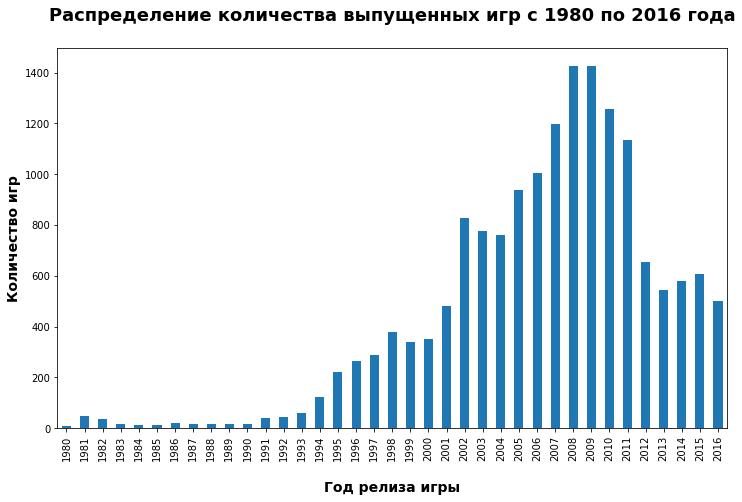

In [21]:
# построим график распределения количества выпущенных игр в течение интересующего нас отрезка времени
year_games_count.plot(y='counts_of_games', kind='bar', figsize=(12, 7), legend=False)

plt.title(label='Распределение количества выпущенных игр с 1980 по 2016 года\n', fontsize=18, fontweight="bold")
plt.xlabel("\nГод релиза игры", fontsize=14, fontweight="bold")
plt.ylabel("Количество игр", fontsize=14, fontweight="bold")

Видим что произошел скачок в разработке игр после 1993 года, так продолжалось до 2009 года, после чего пошел спад и резкое падение в разработке в 2012 году.

Для нашего анализа данные за весь предоставленный период не нужны, а нужны только те, которые отражают тенденции последних лет. В данном случае это данные после 2011 года.

### Изменение продаж по платформам

Определим десять платформ с наибольшими суммарными продажами и построим гистограммы распределения продаж для каждой из этих платформ.

In [22]:
platform_sales_sum = (df
                      .pivot_table(index=['platform'], aggfunc={'total_sales':sum})
                      .nlargest(10, columns='total_sales')
                     )
platform_sales_sum

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [23]:
# создадим новый датафрэйм отфильтрованный по топ-10 платформ:
change_platform_yaers = df.query('platform in @platform_sales_sum.index')
change_platform_yaers

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.00,0.00,-5.0,-5,Unknown,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,-5.0,-5,Unknown,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-5.0,-5,Unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-5.0,-5,Unknown,0.01


Гистограммы построим при помощи цикла:

In [24]:
# создаем список с временным диапазоном, доступным нам:
years_list = []
for i in range(1980, 2017):
    years_list.append(i)

In [25]:
# создаем список с названиями платформ:
platform_list = change_platform_yaers['platform'].unique()

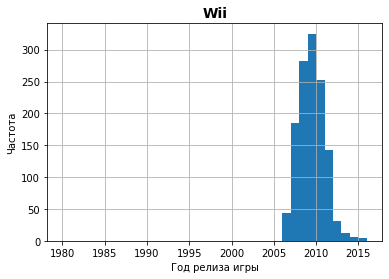

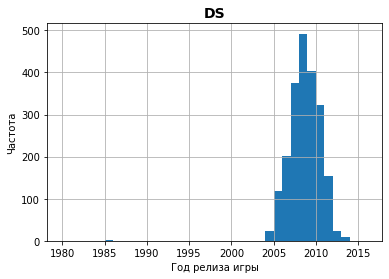

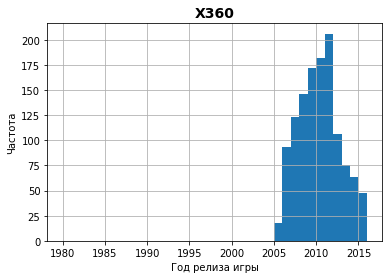

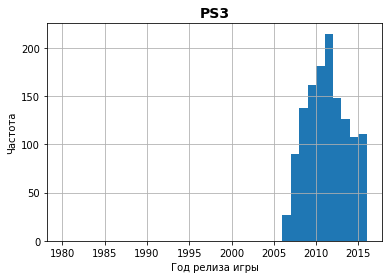

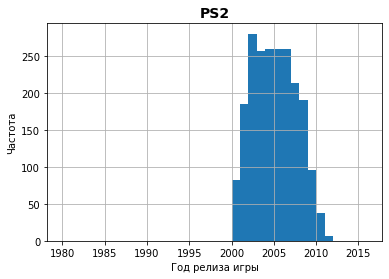

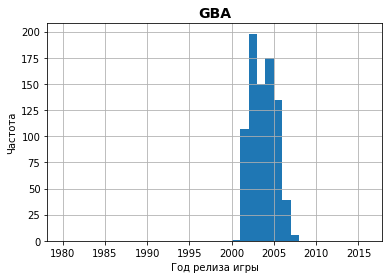

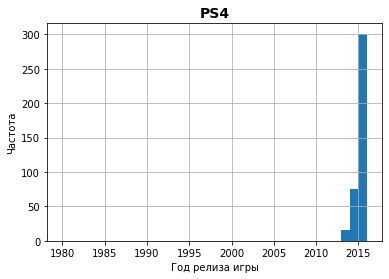

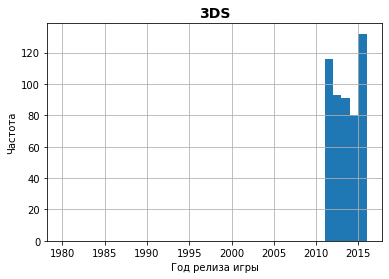

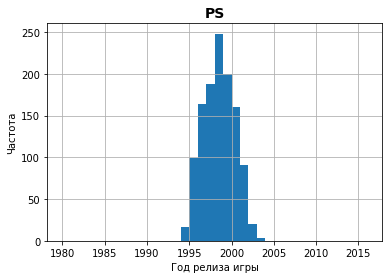

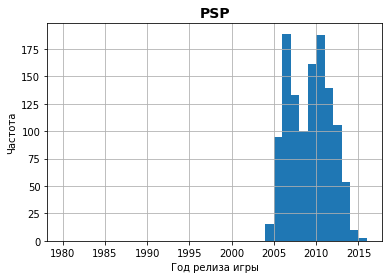

In [26]:
# цикл для построения гистограмм:
for j in range(0, len(platform_list)):
    change_platform_yaers[change_platform_yaers['platform']==platform_list[j]]\
    .plot(kind='hist', bins=years_list, legend=False, grid=True)
    
    plt.title(label=platform_list[j], fontsize=14, fontweight="bold")
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

Графики наглядно представляют поведение платформы за время ее существования, все ее взлеты и падения. Например по графику платформы PC видно, как с развитием технологий компьютеростроения развивалась и разработка видеоигр для пользователей. А некоторые платформы, такие как PSP PS GBA и другие уже прекратили свое существование.
На всех консольных платформах наблюдался резкий скачок продаж в начале и конце существования.

Каков же срок жизни платформы? Попробуем ответить на этот вопрос вычислив среднюю продолжительность жизни.

Для этого принято решение использовать только те платформы, продажи по которым совершенно точно скатились к нулю. Увидеть это можно из частотных гистограмм, построенных для всех платформ из исходного датасета. Также лучше применить медиану для оценки продолжительности жизни, так как есть платформы "умершие" очень быстро, в течение одного - двух лет.

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


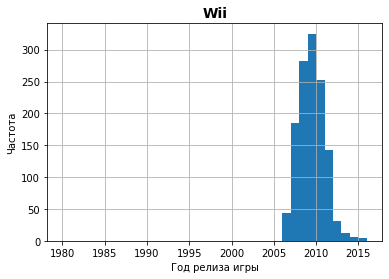

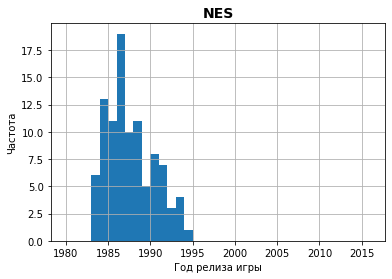

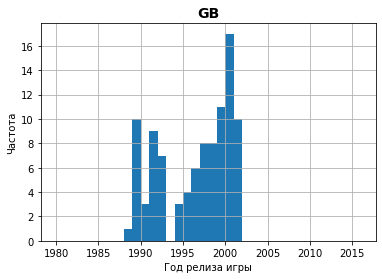

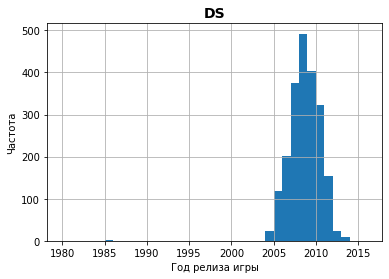

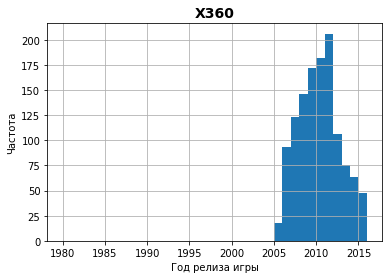

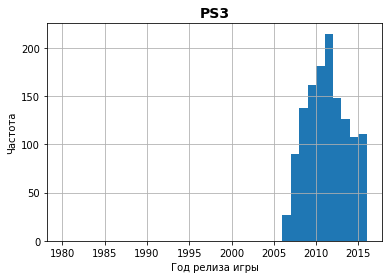

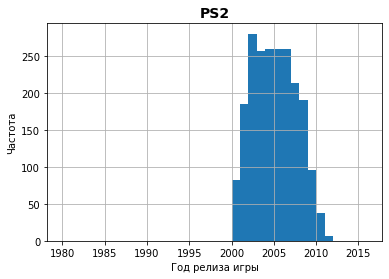

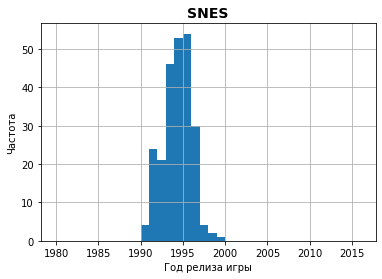

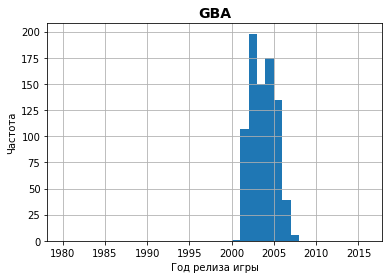

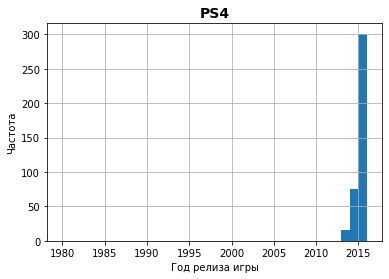

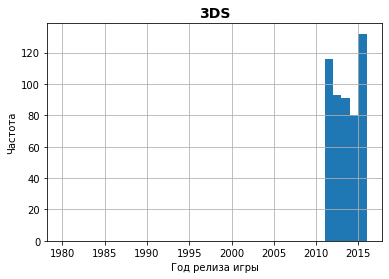

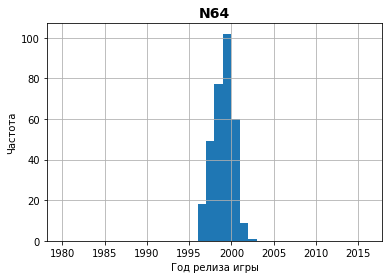

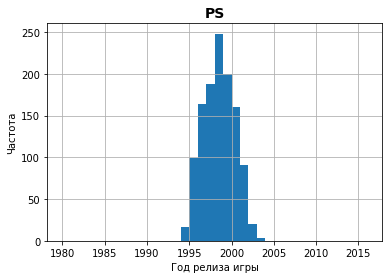

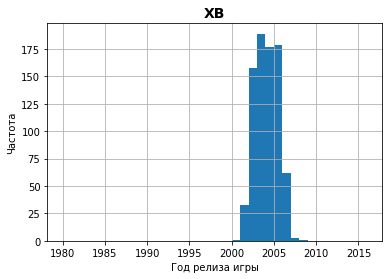

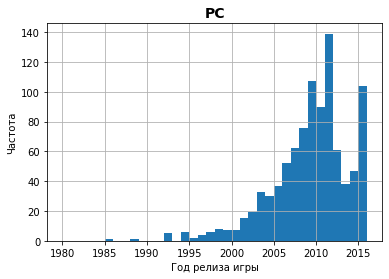

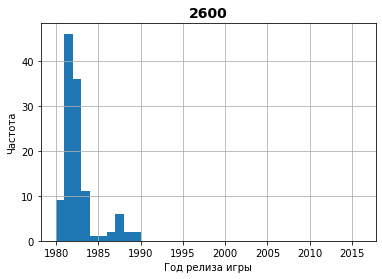

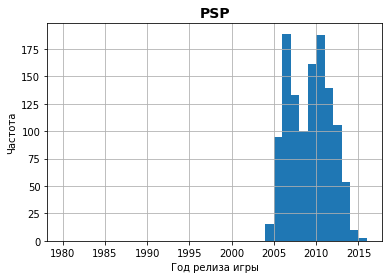

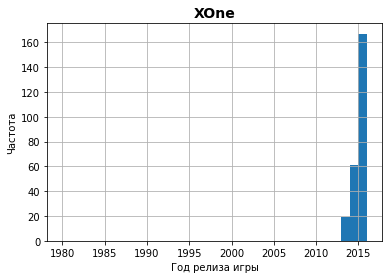

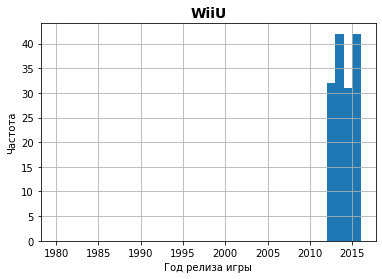

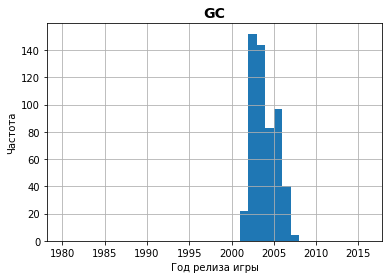

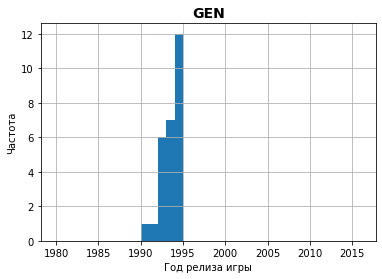

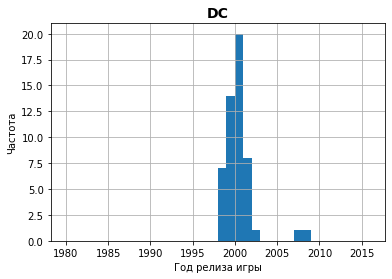

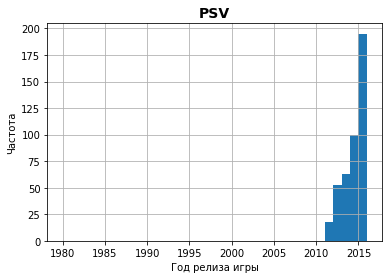

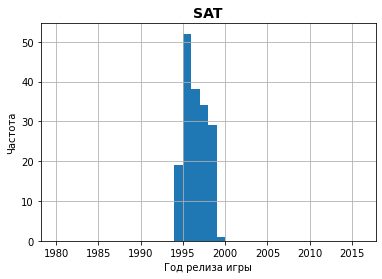

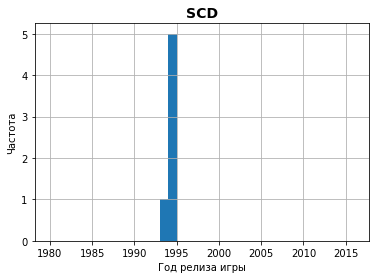

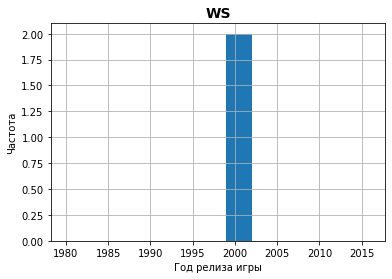

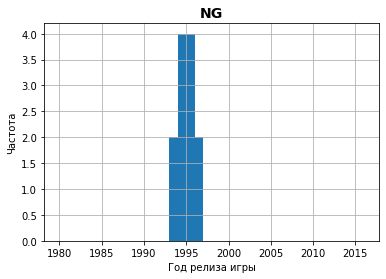

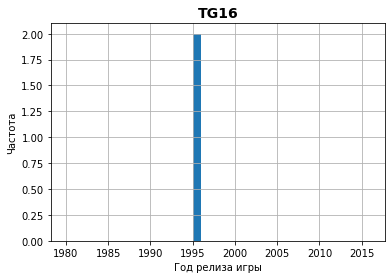

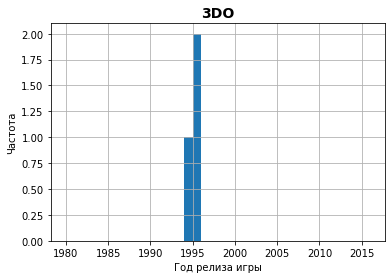

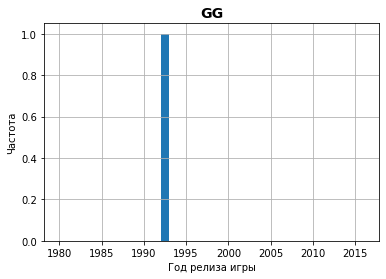

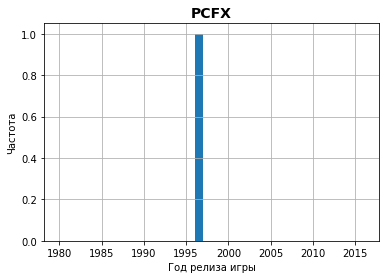

In [27]:
# строим гистограммы распределения продаж для всех платформ на основании исходного датафрейма
all_platform_list = df['platform'].unique()

for i in range(0, len(all_platform_list)):
    df[df['platform']==all_platform_list[i]]\
    .plot(kind='hist', bins=years_list, legend=False, grid=True)
    
    plt.title(label=all_platform_list[i], fontsize=14, fontweight="bold")
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

На основании графиков составим список, в который войдут те платформы, которое нужно исключить из данного анализа

In [28]:
# исключающий список, по которому будем фильтровать
platform_exclude = ['PC', 'X360', 'PS3', '3DS', 'PSV', 'WiiU', 'XOne', 'PS4']

In [29]:
# с помощью сводной таблицы вычислим разность между годом окончания существования платформы и началом
platform_lifetime = df.pivot_table(index='platform', values='year_of_release', aggfunc=[min, max])
platform_lifetime.columns = ['beginnig', 'end']
platform_lifetime['duration'] = platform_lifetime['end'] - platform_lifetime['beginnig']

# отфильтруем полученную таблицу по списку platform_exclude
platform_lifetime_filtred = (platform_lifetime
                     .reset_index()
                     .query('platform not in @platform_exclude')
                    )
platform_lifetime_filtred

,platform,beginnig,end,duration
0,2600,1980,1989,9
1,3DO,1994,1995,1
3,DC,1998,2008,10
4,DS,1985,2013,28
5,GB,1988,2001,13
6,GBA,2000,2007,7
7,GC,2001,2007,6
8,GEN,1990,1994,4
9,GG,1992,1992,0
10,N64,1996,2002,6


In [30]:
mean_lifetime = platform_lifetime_filtred['duration'].median()
mean_lifetime

7.0

Средний срок жизни платформы составляет 7 лет.

Чтобы определить тенденцию изменения продолжительности жизни платформ построим график, на котором отобразим линию тренда по продолжительности жизни.

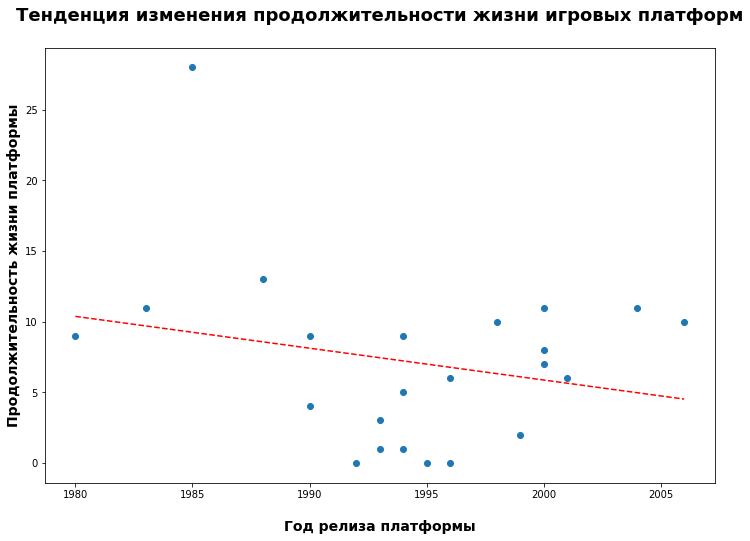

In [31]:
# отсортируем таблицу по годам появления на рынке платформ
# по оси X у нас будет год релиза платформы
# по оси Y продолжительность жизни платформы

platform_lifetime_x = platform_lifetime_filtred.sort_values(by='beginnig')['beginnig']
platform_lifetime_y = platform_lifetime_filtred.sort_values(by='beginnig')['duration']
plt.figure(figsize=(12,8))
plt.scatter(platform_lifetime_x, platform_lifetime_y)

# построим линию тренда
z = np.polyfit(platform_lifetime_x, platform_lifetime_y, 1)
p = np.poly1d(z)
plt.plot(platform_lifetime_x,p(platform_lifetime_x),"r--")

plt.title(label='Тенденция изменения продолжительности жизни игровых платформ\n', fontsize=18, fontweight="bold")
plt.xlabel("\nГод релиза платформы", fontsize=14, fontweight="bold")
plt.ylabel("Продолжительность жизни платформы", fontsize=14, fontweight="bold")


plt.show()

Как видим продолжительность жизни платформ снижается с течением времени.

Также посчитаем через сколько времени в среднем появляется новая платформа и посмотрим ни изменение этого параметра в расматриваемом промежутке времени.

In [32]:
# отсортируем сгруппированную по платформам исходную таблицу по столбцу beginnig по возрастанию

platform_lifetime_speedappear = platform_lifetime.sort_values(by='beginnig')
platform_lifetime_speedappear

,beginnig,end,duration
platform,,,
2600,1980,1989,9
NES,1983,1994,11
DS,1985,2013,28
PC,1985,2016,31
GB,1988,2001,13
SNES,1990,1999,9
GEN,1990,1994,4
GG,1992,1992,0
SCD,1993,1994,1


In [33]:
# значения столбца beginnig переведем в список, чтобы можно было двигаться по нему используя индексы элементов
list_year_begin = list(platform_lifetime_speedappear['beginnig'])

# создаем пустой список куда будет записываться разность в годах между релизами новых платформ
list_year_begin_dif = []

# вычисляем разность в цикле
for i in range(0, len(list_year_begin)-1):
    difference = list_year_begin[i+1] - list_year_begin[i]
    list_year_begin_dif.append(difference)

# добавим последним значением NaN чтобы можно было присоединить полученные значения к датафрейму platform_lifetime_speedappear
list_year_begin_dif.append(np.nan)

In [34]:
# добавляем полученные значения к датафрейму
platform_lifetime_speedappear['dif'] = list_year_begin_dif

# удаляем строку с пропуском чтобы можно было построить график
platform_lifetime_speedappear = platform_lifetime_speedappear.dropna()
platform_lifetime_speedappear

,beginnig,end,duration,dif
platform,,,,
2600,1980,1989,9,3.0
NES,1983,1994,11,2.0
DS,1985,2013,28,0.0
PC,1985,2016,31,3.0
GB,1988,2001,13,2.0
SNES,1990,1999,9,0.0
GEN,1990,1994,4,2.0
GG,1992,1992,0,1.0
SCD,1993,1994,1,0.0


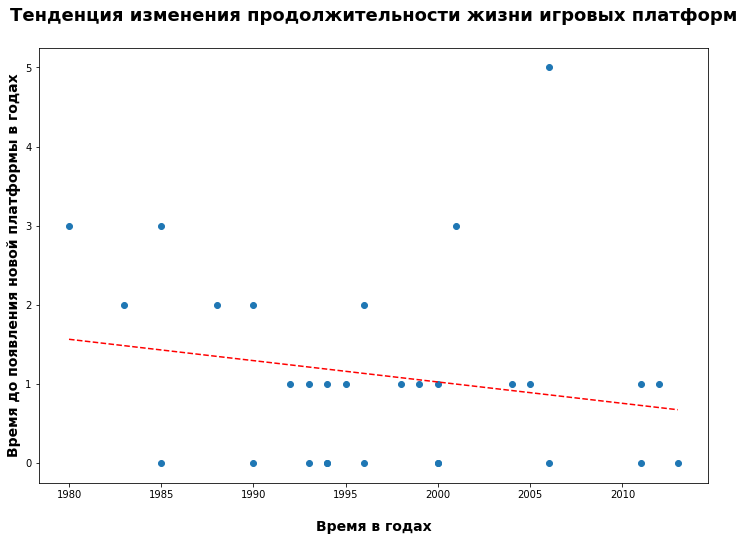

In [35]:
# определяем значения по осям
# по оси Х отложим время
# по Y полученную разность
# пострим точечный график рассеяния

speedappear_x = platform_lifetime_speedappear['beginnig']
speedappear_y = platform_lifetime_speedappear['dif']
plt.figure(figsize=(12,8))
plt.scatter(speedappear_x, speedappear_y)

# наложим на график рассеяия тренд
z = np.polyfit(speedappear_x, speedappear_y, 1)
p = np.poly1d(z)
plt.plot(speedappear_x,p(speedappear_x),"r--")

plt.title(label='Тенденция изменения продолжительности жизни игровых платформ\n', fontsize=18, fontweight="bold")
plt.xlabel("\nВремя в годах", fontsize=14, fontweight="bold")
plt.ylabel("Время до появления новой платформы в годах", fontsize=14, fontweight="bold")


plt.show()

In [36]:
platform_lifetime_speedappear['dif'].median()

1.0

Как видим тренд у нас отрицательный. Это означает, что время между появлениями новых платформ сокращается. Все быстрее и быстрее появляются новые платформы.

Среднее время появления новой платформы составляет 1 год.

### Потенциально прибыльные платформы

Для дальнейшего анализа выберем данные за последние несколько лет, так как они отражают последние тенденции и на их основании можно делать различные предположения о будущем поведении.

Актуальным периодом будем считать 2012 - 2016 года.

Сделаем срез данных по этому периоду.

In [37]:
relevant_years = []
for i in range(2012, 2017):
    relevant_years.append(i)

df_relevant = df.query('year_of_release in @relevant_years')
df_relevant

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-5.0,-5,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-5.0,-5,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-5.0,-5,Unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-5.0,-5,Unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-5.0,-5,Unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-5.0,-5,Unknown,0.01


Посмотрим какие платформы лидируют по суммарным продажам в этом периоде времени:

In [38]:
rel_platform_sales_sum = (df_relevant
                          .pivot_table(index='platform', values='total_sales', aggfunc=sum)
                          .sort_values(by='total_sales', ascending=False)
                         )
rel_platform_sales_sum

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


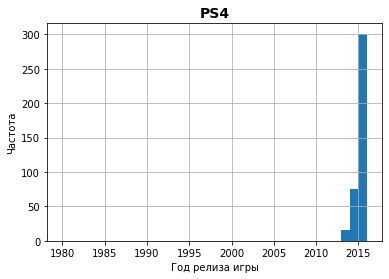

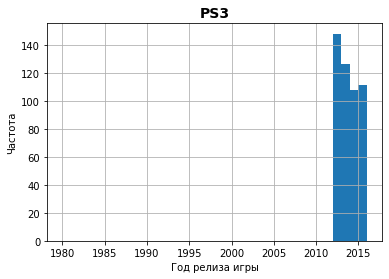

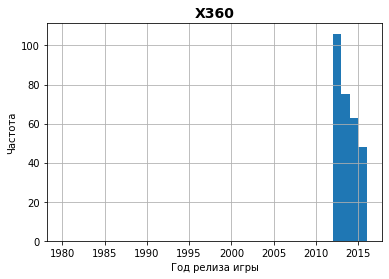

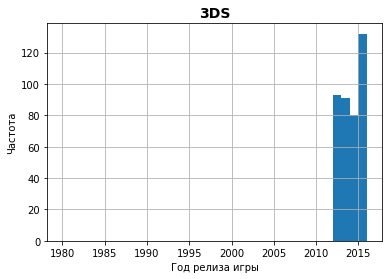

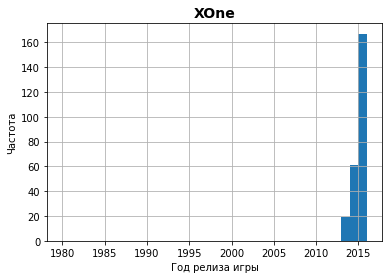

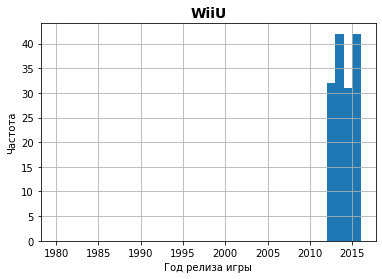

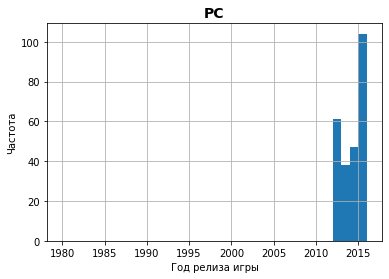

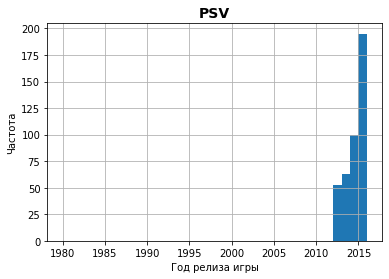

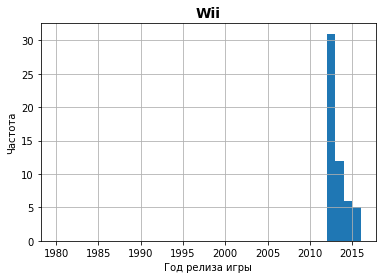

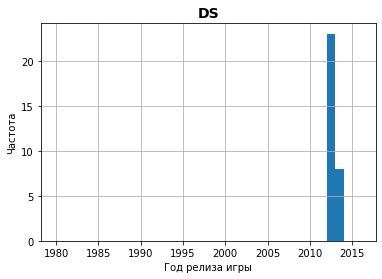

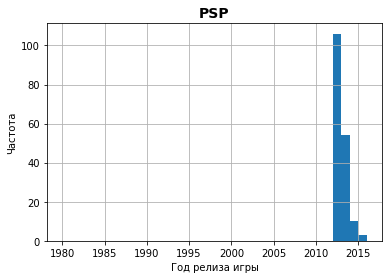

In [39]:
for j in range(0, len(rel_platform_sales_sum.index)):
    df_relevant[df_relevant['platform']==rel_platform_sales_sum.index[j]]\
    .plot(kind='hist', bins=years_list, legend=False, title=rel_platform_sales_sum.index[j], grid=True)
    
    plt.title(label=rel_platform_sales_sum.index[j], fontsize=14, fontweight="bold")
    plt.xlabel("Год релиза игры")
    plt.ylabel("Частота")

In [40]:
# посмотрим сколько было платформ в исходном датасете
len(df['platform'].unique())

31

В актуальном периоде, который мы выбрали, из 31 платформы остались только 11. Из этих 11 платформы DS и PSP можно исключить из потенциально прибыльных платформ, т.к. DS уже прекратила свое существование, а у PSP продажи практически равно нулю.
Список потенциально прибыльных платформ в актуальном периоде выглядит так:

In [41]:
relevant_platforms = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii']

### Диаграммы размаха по продажам игр

(0.0, 2.5)

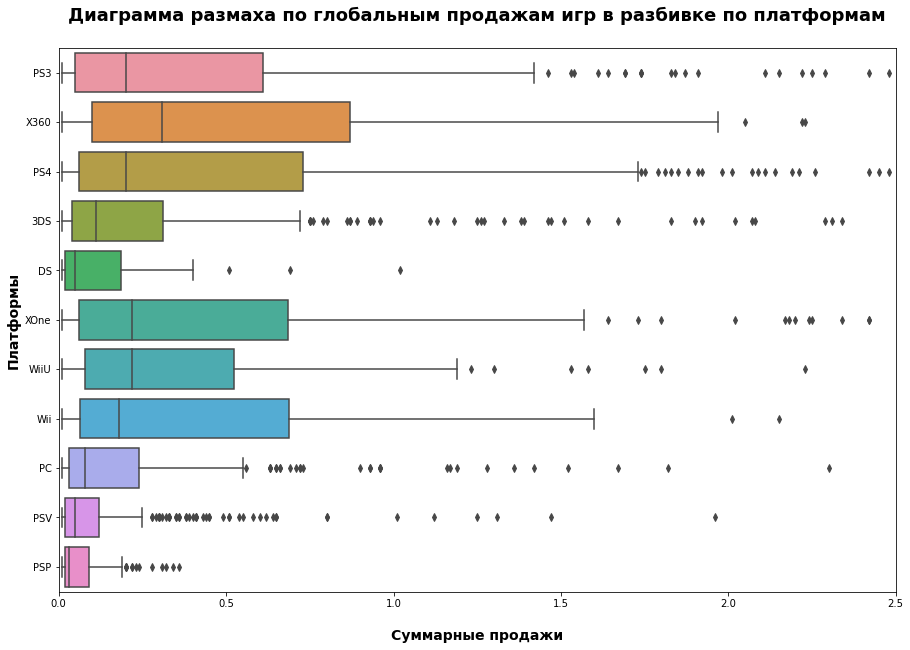

In [42]:
# построим все "ящики с усами" на одном графике для удобства
# используем библиотеку seaborn

plt.figure(figsize=(15,10))
sns.boxplot(data=df_relevant, x='total_sales', y='platform')

plt.title(label='Диаграмма размаха по глобальным продажам игр в разбивке по платформам\n', fontsize=18, fontweight="bold")
plt.xlabel("\nСуммарные продажи", fontsize=14, fontweight="bold")
plt.ylabel("Платформы", fontsize=14, fontweight="bold")
plt.xlim(0, 2.5)

По данным диаграммам легко определить была ли популярна платформа в интересующий нас отрезок времени. Определить можно по объему продаж, входящему в межквартильный размах и медианному значению, чем они выше тем популярнее платформа. Например PS4 или X360 несомненно популярны.

### Зависимость продаж от оценок критиков и пользователей

Выберем несколько популярных и потенциально прибыльных платформ и посмотрим как продажи на этих платформах зависят от оценок игр.

3DS


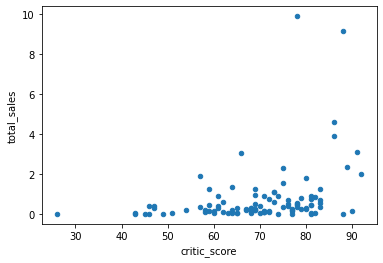

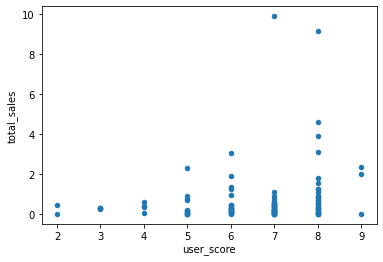

critic_score    0.310553
user_score      0.194176
total_sales     1.000000
Name: total_sales, dtype: float64
DS


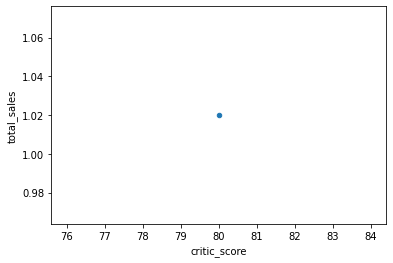

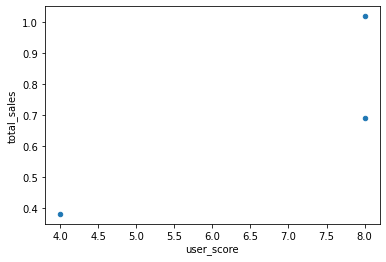

critic_score   NaN
user_score     NaN
total_sales    NaN
Name: total_sales, dtype: float64
PC


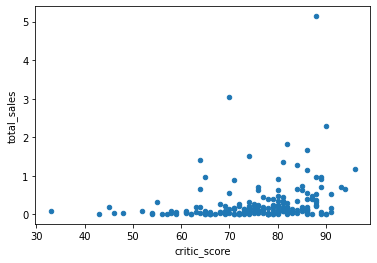

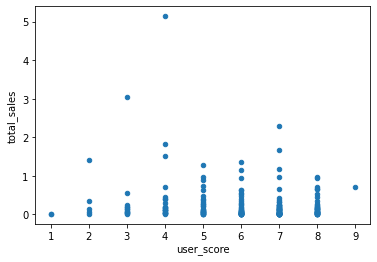

critic_score    0.236008
user_score     -0.134484
total_sales     1.000000
Name: total_sales, dtype: float64
PS3


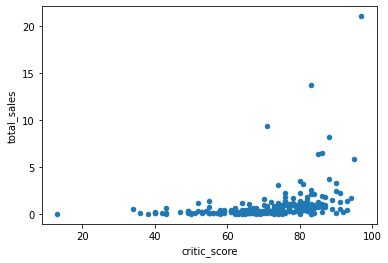

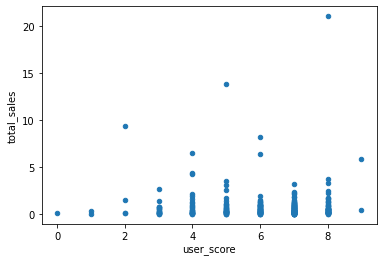

critic_score    0.331057
user_score      0.009512
total_sales     1.000000
Name: total_sales, dtype: float64
PS4


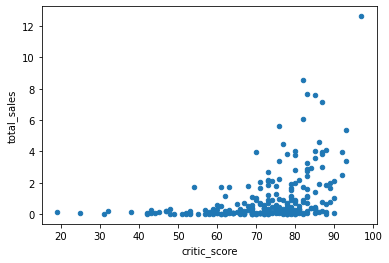

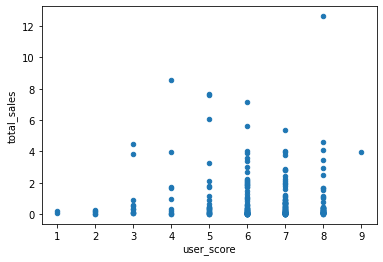

critic_score    0.405895
user_score     -0.027162
total_sales     1.000000
Name: total_sales, dtype: float64
PSP


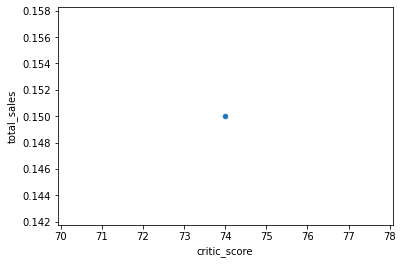

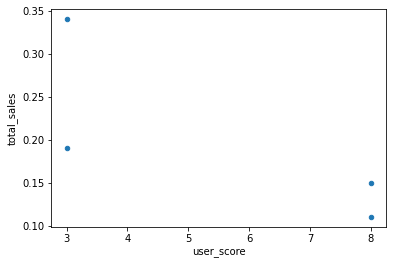

critic_score   NaN
user_score     NaN
total_sales    NaN
Name: total_sales, dtype: float64
PSV


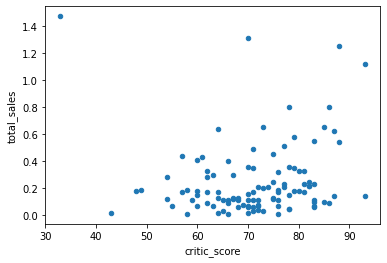

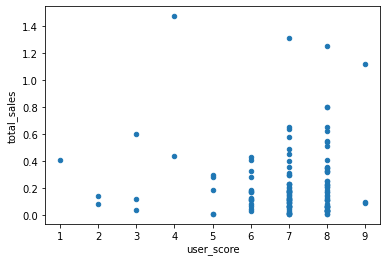

critic_score    0.093988
user_score     -0.001015
total_sales     1.000000
Name: total_sales, dtype: float64
Wii


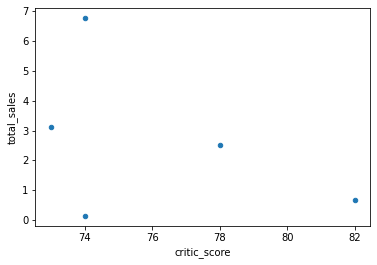

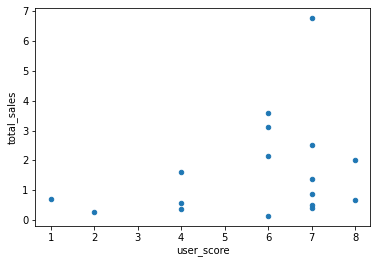

critic_score   -0.424341
user_score      0.006403
total_sales     1.000000
Name: total_sales, dtype: float64
WiiU


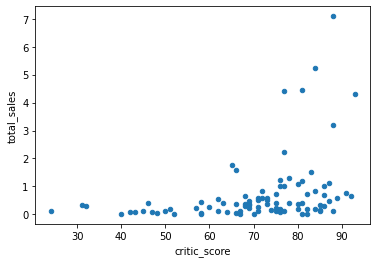

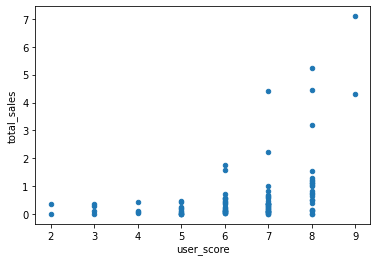

critic_score    0.350882
user_score      0.394800
total_sales     1.000000
Name: total_sales, dtype: float64
X360


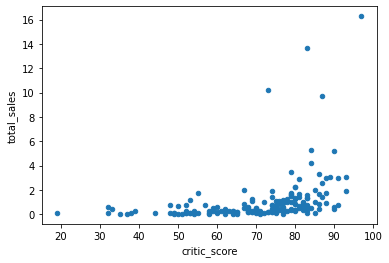

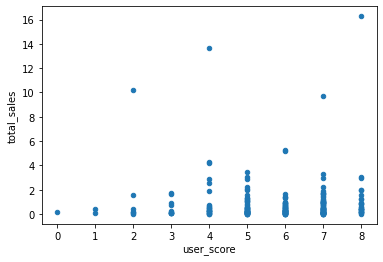

critic_score    0.360573
user_score     -0.004465
total_sales     1.000000
Name: total_sales, dtype: float64
XOne


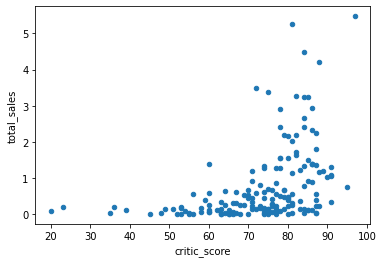

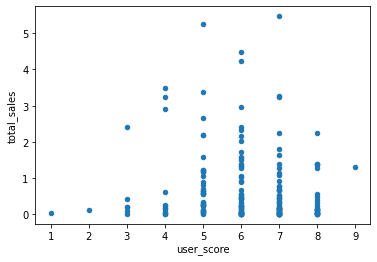

critic_score    0.410422
user_score     -0.111769
total_sales     1.000000
Name: total_sales, dtype: float64


In [43]:
# используем цикл для построения диаграмм рассеяния
# и расчета коэффициента корреляции
for platform, relevant_platforms in  df_relevant.groupby('platform'):
    print('='*30)
    print(platform)
    relevant_platforms[relevant_platforms['critic_score'] != -5].plot(kind='scatter', x='critic_score', y='total_sales')
    relevant_platforms[relevant_platforms['user_score'] != -5].plot(kind='scatter', x='user_score', y='total_sales')
    plt.show()
    print(relevant_platforms[(relevant_platforms['critic_score'] != -5) 
                        & (relevant_platforms['user_score'] != -5)]
                       [['critic_score', 'user_score', 'total_sales']].corr()['total_sales'])

Исходя из графиков расеяния можно сказать, что объем продаж довольно резко возрастает при оценке критиков от 60 и выше, до этой отметки продажи малы.
Зависимость продаж от оценок пользователей менее выраженная, но можно сказать, что продажи растут начиная с отметок в 2-4 балла.

В целом коэффициент корреляции показывает, что зависимость продаж от оценок критиков сильнее, чем от оценок пользователей. За исключением платформы WiiU, где коэффициент корреляции примерно одинаков.

### Общее распределение игр по жанрам

Рассмотрим как распределяются игры в зависимости от жанра.

Сначала оценим количественное распределение по жанрам:

<AxesSubplot:ylabel='genre'>

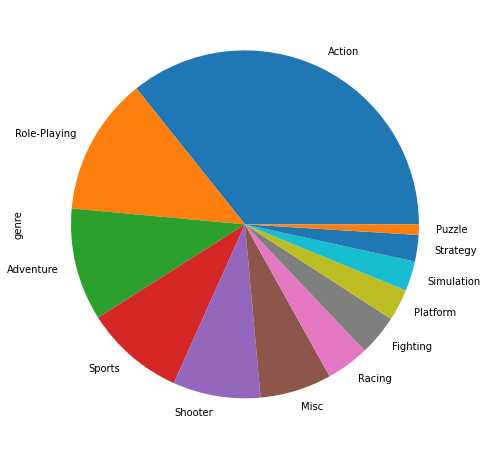

In [44]:
df_relevant['genre'].value_counts().plot(kind='pie', figsize=(8, 8), legend=False)

Жанр Action отрезал себе львиную долю пирога (наверное потому, что под action можно приписать любую динамичную игру, в том числе и shooter например), далее идут игры ролевые, приключения, спортивные и стрелялки. Наименьшее количество игр в жанре Puzzle (довольно специфичный вид игры, да и сюжетом не разгуляешся).

Посмотрим как распределяются продажи в зависимости от жанра игры:

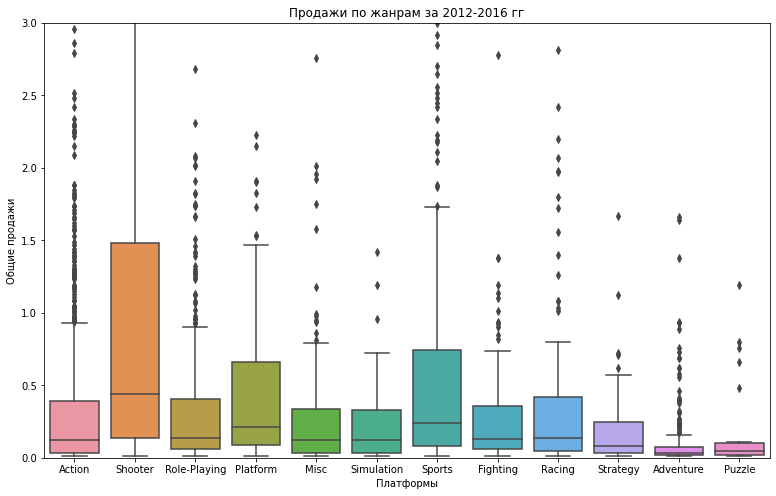

In [45]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = df_relevant, y = 'total_sales', x='genre')
    .set(title = 'Продажи по жанрам за 2012-2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3)))

plt.show()

Видим немного другую картину. Жанр Shooter лидирует в продажах, далее Sports, Platform, ролевые и Action. Однако игры жанра  Adventure на этот раз в конце списка.

## Портрет пользователя

Составим портрет пользователя для каждого региона (NA, EA, JP).

### ТОП-5 платформ

Для каждого региона посчитаем суммарные продажи по платформам и определим 5 самых популярных.

In [46]:
top5_platforms_per_region = (df_relevant
        .pivot_table(index='platform', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
       )
   
top5_platforms_per_region

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


Построим графики распределения продаж по платформам оставив самые популярные:

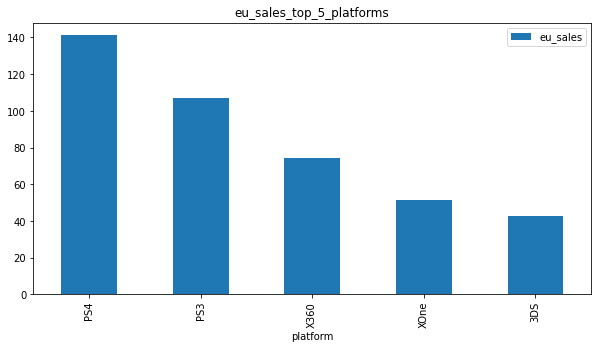

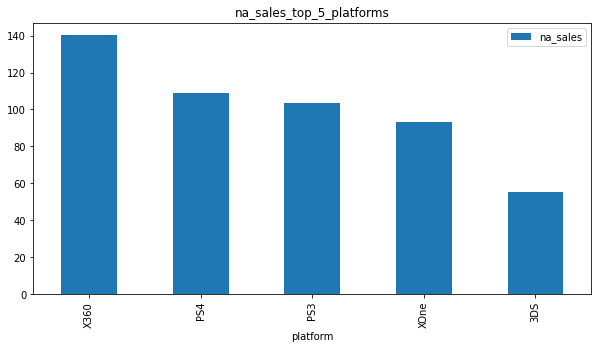

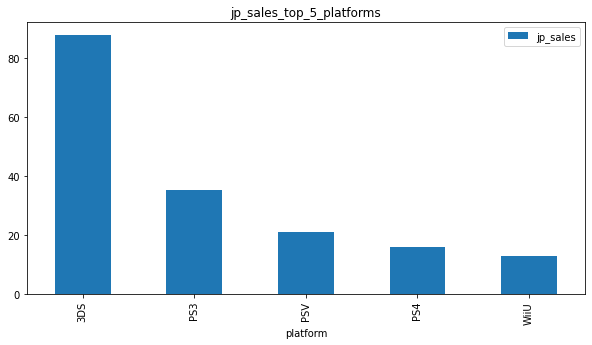

In [47]:
# список регионов для цикла
region = ['eu_sales', 'na_sales', 'jp_sales']

for i in range(0, 3):
    (top5_platforms_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_platforms')
    )

В Европе самая популярная платформа PS4, в Северной Америке X360, в Японии - Nintendo 3DS. Американцы и японцы поддерживают своих производителей.

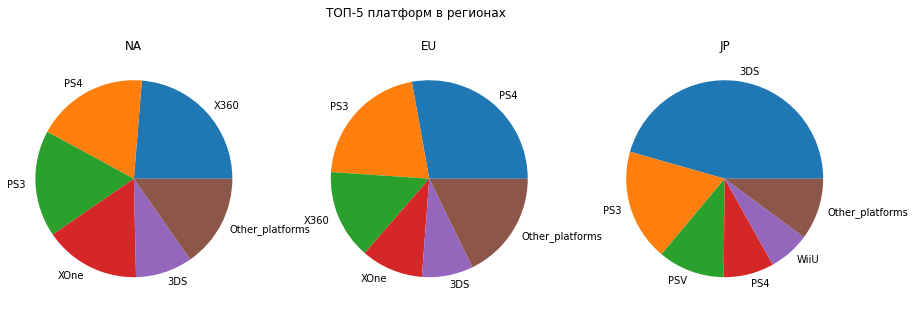

In [48]:
# задаем список регионов
countries = df_relevant.columns[4:7]
# начертим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 платформ в регионах')
for i in range(3):
  # выберем 5 самых продающих платформ
  df_i = (df_relevant.groupby('platform')[countries[i]].sum().
             reset_index().
             sort_values(countries[i], ascending = False, ignore_index = True).
             head(5))
  # занесем все остальыне продажи в Other_platforms
  df_i = df_i.append({'platform': 'Other_platforms', countries[i]: df_relevant[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
  axs[i].pie(df_i[countries[i]], labels = df_i['platform'])

  # Зададим название региона.
  axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

### ТОП-5 жанров

Для каждого региона посчитаем суммарные продажи по жанрам и определим 5 самых популярных.

In [49]:
top5_genre_per_region = (df_relevant
        .pivot_table(index='genre', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
       )
   
top5_genre_per_region

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


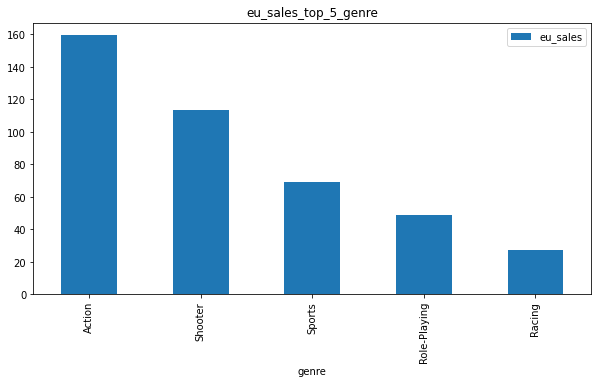

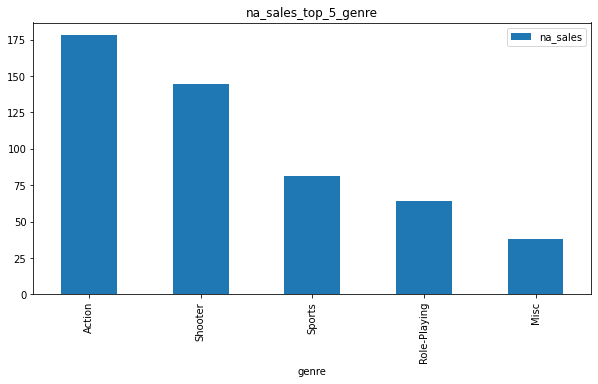

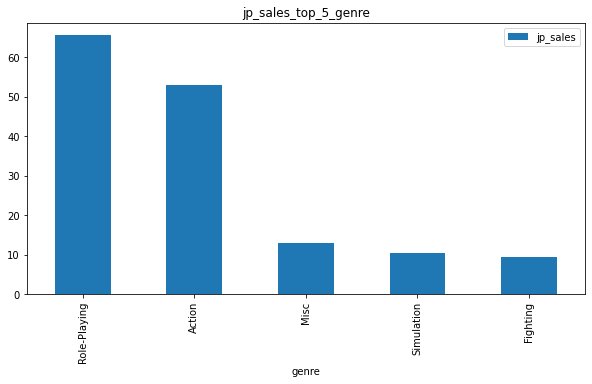

In [50]:
for i in range(0, 3):
    (top5_genre_per_region
     .nlargest(5, columns=region[i])
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_top_5_genre')
    )

Пользователи Европы и Северной Америки практически идентичны, за исключением последнего жанра: в Европе это гонки, а в Северной Америке - аркады. Пользователи Японии как всегда особенные, предпочитают ролевые игры, но также разделяют любовь жителей запада к жанру Action. В Японии жанры Role и Action лидеры в продажах с большим и резким отрывом от остальных жанров.

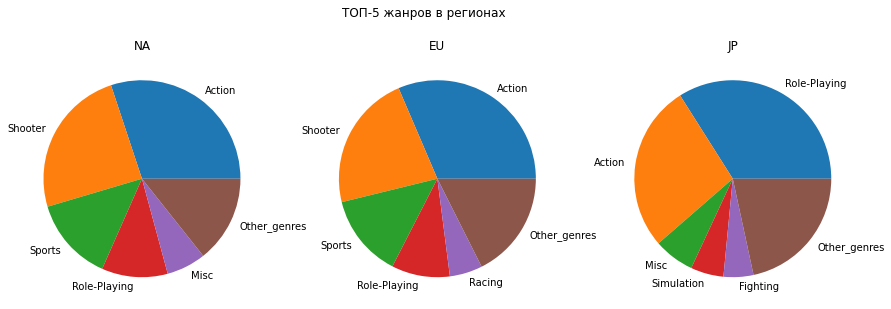

In [51]:
# задаем список регионов
countries = df_relevant.columns[4:7]
# начертим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # выберем 5 самых продающих платформ
  df_i = (df_relevant.groupby('genre')[countries[i]].sum().
             reset_index().
             sort_values(countries[i], ascending = False, ignore_index = True).
             head(5))
  # занесем все остальыне продажи в Other_platforms
  df_i = df_i.append({'genre': 'Other_genres', countries[i]: df_relevant[countries[i]].sum() - df_i[countries[i]].sum()}, ignore_index= True)
  axs[i].pie(df_i[countries[i]], labels = df_i['genre'])

  # Зададим название региона.
  axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

### Рейтинг ESRB

Аналогично посмотрим как влияет рейтинг на продажи в каждом регионе.

In [52]:
rating_sum = df_relevant.pivot_table(index='rating', aggfunc={'na_sales':sum, 'eu_sales':sum, 'jp_sales':sum})
  
rating_sum

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
Unknown,91.50,108.84,103.31


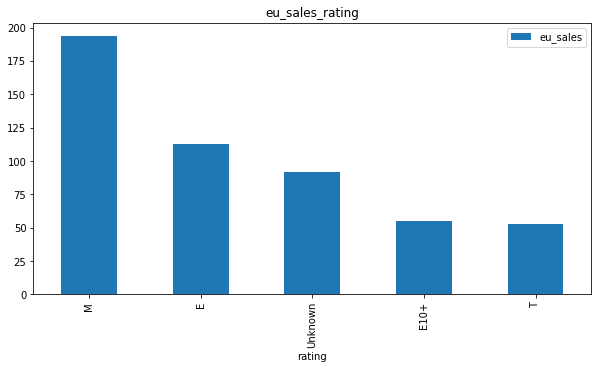

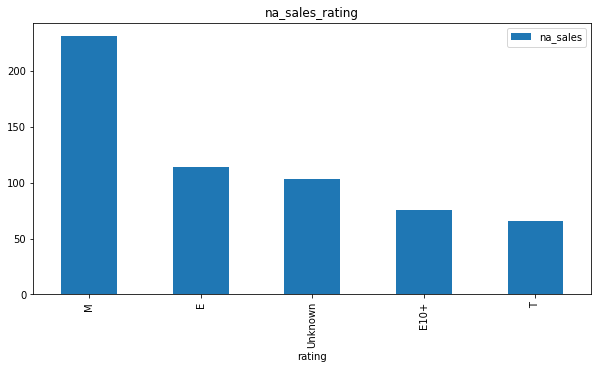

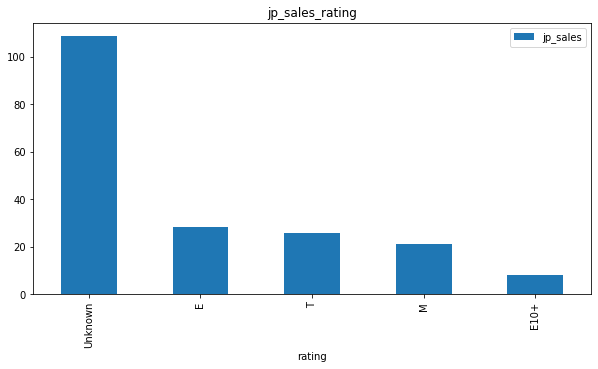

In [53]:
for i in range(0, 3):
    (rating_sum
     .sort_values(by=region[i], ascending=False)
     .plot(y=region[i], kind='bar', figsize=(10, 5), title=region[i]+'_rating')
    )

В Америке и Европе идентичное распределение продаж в зависимости от рейтингов: преобладают, с большим отрывом, игры для взрослых, далее игры для всех, на третьем месте игры с неизвестным рейтингом и замыкают игры 13+.
В Японии все опять не так: лидируют игры с неизвестным рейтингом с большим отрывом, меньше всего популярны игры 10+.

В целом можно сказать, что американцы и европейцы схожи в выборе платформ, жанров и возрастного рейтинга игр. То есть портреты пользователей идентичны.
Японцы сильно отличаются в предпочтениях от западных игроков, в некоторых случаях диаметрально.

## Проверка гипотез

**Первая гипотеза**

Первая гипотеза которую нужно проверить - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы:

- H0 - средние пользовательские рейтинги платформ Xbox One и PC равны (в H0 всегда используется знак равенства);
- H1 - средний пользовательский рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC .

Альтернативная гипотеза у нас двусторонняя, так как средний рейтинг может отличаться от как в большую так и в меньшую сторону.

Чтобы проверить гипотезу о равенстве средних двух выборок применим метод scipy.stats.ttest_ind (array1, array2, equal_var), где equal_var - параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать).

In [54]:
# создадим 2 таблицы со среднмими пользовательские рейтинги платформ Xbox One и PC

xbox_one_ttest = df_relevant[(df_relevant['platform']=='XOne')]['user_score'] != -5
pc_ttest = df_relevant[(df_relevant['platform']=='PC')]['user_score'] != -5

# проверим дисперсии рассматриваемых выборок
xbox_one_ttest_var = np.var(xbox_one_ttest, ddof=1)
pc_ttest_var = np.var(pc_ttest, ddof=1)

print('Дисперсия платформы Xbox One:', round(xbox_one_ttest_var, 2))
print()
print('Дисперсия платформы PC:', round(pc_ttest_var, 2))

Дисперсия платформы Xbox One: 0.19

Дисперсия платформы PC: 0.15


In [55]:
# уровень значимости 5%
alpha = 0.05

results = st.ttest_ind(xbox_one_ttest, pc_ttest, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.018962395633071668
Отвергаем нулевую гипотезу


In [56]:
# Комментарий ревьюера
xbox_one_ttest.min(), pc_ttest.min()

(False, False)

р-уровень значимости составил почти 1,9%, что меньше 5% => средний рейтинг платформ Xbox One и PC статистически отличается.

**Вторая гипотеза**

Вторая гипотеза для проверки звучит так - средние пользовательские рейтинги жанров Action и Sports разные.

- H0 - средние пользовательские рейтинги жанров Action и Sports равны (в H0 всегда используется знак равенства);
- H1 - средние пользовательские рейтинги жанров Action и Sports различаются.

В этой гипотезе нам также нужно сравнить средние двух выборок, поэтому применим тот же тест ttest_ind.

In [57]:
# создадим 2 таблицы со среднмими пользовательские рейтинги жанров Action и Sports

action_ttest = df_relevant[(df_relevant['genre']=='Action')]['user_score'] != -5
sports_ttest = df_relevant[(df_relevant['genre']=='Sports')]['user_score'] != -5

# проверим дисперсии рассматриваемых выборок
action_ttest_var = np.var(action_ttest, ddof=1)
sports_ttest_var = np.var(sports_ttest, ddof=1)

print('Дисперсия жанра Action:', round(action_ttest_var, 2))
print()
print('Дисперсия жанра Sports:', round(sports_ttest_var, 2))

Дисперсия жанра Action: 0.25

Дисперсия жанра Sports: 0.2


Разница между дисперсиями выборок составляет 1,13, что при данном уровне дисперсии довольно большая разница и считать дисперсии выборок равными нельзя, поэтому зададим аргумент equal_var=False.

In [58]:
# уровень значимости зададим равным 5%
alpha = 0.05

results = st.ttest_ind(action_ttest, sports_ttest, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.022994513430088e-12
Отвергаем нулевую гипотезу


In [59]:
# Комментарий ревьюера
action_ttest.min(), sports_ttest.min()

(False, False)

p-уровень значимости слишком мал, гораздо меньше определенного нами порогового значения в 5% => средние пользовательские рейтинги жанров Action и Sports статистически значимо различаются.

## Вывод

Проведя исследовательский анализ данных о продажах видеоигр в мире можно сказать следующее:

- В первую очередь следует обратить внимание на потенциально прибыльные игровые платформы. Таковыми являются 'PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii'. Продажи по платформам 'PS3', 'X360', 'Wii' падают, но все еще могут принести некоторую прибыль. Нужно иметь ввиду что в разных регионах популярные платформы могут отличаться, например платформа 3DS очень популярна в Японии, но менее популярна в Европе и Америке. Платформы 3DS, PS3, PS4 популярны во всех регионах.
- Среди жанров видеоигр также можно выделить наиболее популярные и перспективные, например жанр Action перспективный во всех регионах, а также жанры Shooter, Sports и Role-Playing являются потенциально прибыльными и следует учесть это при планировании. Следует быть аккуратными с таким жанром как Adventure. Несмотря на то, что игры с таким жанром занимают серьезную долю рынка в количественном отношении, их продажи очень невысоки.
- К сожелению очень многие игры не имеют рейтинга ESRB, поэтому данные анализа здесь не совсем полные и корректные. Но даже сейчас можно сказать, что среди игроков Европы и Северной Америки наибеолее популярны игры для взрослых и для любого возраста. В то время как в Японии с большим отрывом лидируют игры, для которых рейтинг не установлен.
- Большое влияние на продажи игр оказывают их оценки. Оценки делятся на оценки критиков и пользователей. Мы выявили, что оценки критиков имеют в два раза более тесную связь с продажами, чем оценки пользователей. Поэтому стоит учитывать только оценки критиков. При этом нами была выявлена закономерность: продажи видеоигр начинают активно расти при оценки критиков от 60 пунктов и выше.
- В целом пользователи из регионов Европа и Северная Америка очень схожи в своих предпочтених и можно объеденить усилия и рекламный контент для этих направлений. Но необходимо более тщательно подготовить компанию в Японии.

На оснвоании изложенного потратить рекламный бюджет предлагается на продвижение платформ 'PS4', 'PS3', игры жанров  Action, Shooter, Sports и Role-Playing с рейтингом ESRB для взрослых.

Входе проверки статестических гипотез за актуальные период (в данной работе определен как 2012-2016 гг.) установлено, что:

* средний рейтинг платформ Xbox One и PC статистически отличается;
* средние пользовательские рейтинги жанров Action и Sports статистически значимо различаются.